# Recording and Histogramming Noise

In [1]:
import skutils
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import os

Skutils is in beta, please contact support@skutek.com with bugs, issues, and questions


## Connect to your digitizer

Fill in this spot with your own FemtoDAQ device location

In [2]:
# Fill in this spot with your own FemtoDAQ device location
DIGITIZER_URL = "http://vireo-000019.tek"
digitizer = skutils.FemtoDAQController(DIGITIZER_URL, skip_version_check=True)

## Configure a Data Collection Run

In [3]:
NUMBER_OF_EVENTS = 1000
# Configuring the vireo
# Configure the vireo to record both channels, with 4096 samples in the waveform
# Use eventcsv as it's easier to demo
recording_channels = [0, 1]
digitizer.configureRecording(
    recording_channels,
    number_of_samples_to_capture=4096,
    file_recording_format="eventcsv",
    file_recording_data_output="waveforms",
)
# enable triggers
digitizer.setEnableTrigger(0, True)
digitizer.setEnableTrigger(1, True)
# Default offset
digitizer.setDigitalOffset(0, 0)
digitizer.setDigitalOffset(1, 0)
digitizer.setAnalogOffsetPercent(0, 0)
digitizer.setAnalogOffsetPercent(1, 0)

# Allow us to see the beginning of the pulse, if we wish.
digitizer.setTriggerXPosition(100)
# This is the only digitizer we're using here, set the global id to 0
digitizer.setGlobalId(0)
# We want to capture the rising edge, and we want a "fairly" sensitive trigger
digitizer.setTriggerEdge(0, "rising")
digitizer.setTriggerEdge(1, "rising")
digitizer.setTriggerSensitivity(0, 1)
digitizer.setTriggerSensitivity(1, 1)
# Trigger windows
# The trigger active window can also be called the "Coincidence window"
digitizer.setTriggerActiveWindow(4096)
digitizer.setTriggerAveragingWindow(0, 1)
digitizer.setTriggerAveragingWindow(1, 1)

# Coincidence settings, I want both channels to have triggered in order to be a true "trigger" and recording the data point
digitizer.configureCoincidence("multiplicity", trigger_multiplicity=1)

## Collect Data

In [4]:
digitizer.start(NUMBER_OF_EVENTS)

# wait until we're done collecting data or 5 minutes has passed
timed_out = digitizer.waitUntil(timeout_time=360)
# Technically not needed, just for posterity
digitizer.stop()

## Download your data

In [5]:
# in this case I am storing them in a temporary directory to not fill directories on my system
file_list = digitizer.downloadLastRunDataFiles(tempfile.gettempdir())

Vireo-000019 (http://vireo-000019.tek) Controller : downloaded `API_Recording_09.53.37AM_May15_2025_seq000001.ecsv` to 'C:\Users\Jeff\AppData\Local\Temp\API_Recording_09.53.37AM_May15_2025_seq000001.ecsv'


## Calculate Pulse Heights from your Waveforms

In [6]:
pulse_heights = [[] for _ in digitizer.channels]

event_count = 0
for event in skutils.quickLoad(file_list):
    for channel in event.channel_data:
        assert channel.has_wave
        height = np.max(channel.wave)

        pulse_heights[channel.channel].append(height)

## Build a Histogram

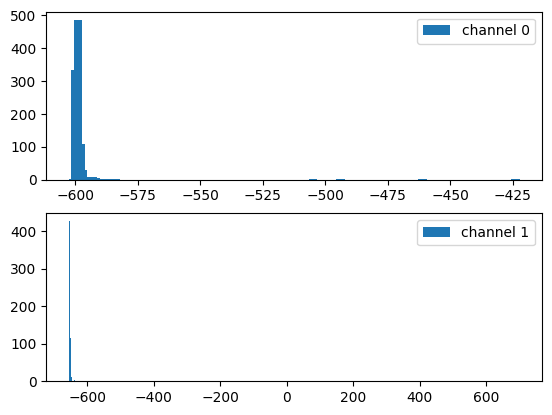

In [7]:
total_range = digitizer.adc_max_val - digitizer.adc_min_val
total_bins = total_range // 4
hist_builder = []
for height_list in pulse_heights:
    hist_builder.append(np.histogram(height_list, bins=total_bins))


fig, axes = plt.subplots(2, 1)

for i in range(len(hist_builder)):
    hist, edges = hist_builder[i]
    axes[i].bar(edges[1:], hist, width=3.5, label=f"channel {i}")
    axes[i].legend()

plt.show()